In [1]:
import time
import pandas as pd
import os.path
import numpy as np
import scipy.stats as stats
from keras.callbacks import History


import matplotlib.pyplot as plt

2022-06-27 13:01:49.253419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 13:01:49.253438: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sys import argv
import json
import joblib


In [3]:
def read_workload_csv(filepath) -> pd.DataFrame:
    """Read and clean csv workload from filepath"""
    file_exists = os.path.exists(filepath)
    
    if not file_exists:
        raise FileNotFoundError
        return
    
    df = pd.read_csv(filepath)
    
    # drop id column
    df = df.iloc[: , 1:]
    
    return df

In [4]:
base_path = "../postgres/data/rr_week/rt/sim"

def load_workloads(ids):
    """Loads and combine a list of workloads"""
    df = read_workload_csv(f"{base_path}/workload_{ids[0]}_sim.csv")
    
    for i in ids[1:]:
        df_tmp = read_workload_csv(f"{base_path}/workload_{i}_sim.csv")
        
        df = pd.concat([df, df_tmp])
    
    return df
        

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dfi = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dfi.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dfi.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:
ids = np.arange(101,114+1)


df = load_workloads(ids)
df.set_index(pd.to_datetime(df['timestamp']), inplace=True)
df.drop('timestamp', axis=1, inplace=True)
df['time_delta'] = df['time_delta']*1000*100


# OUTLIERS ELIMINATION WITH Z-VALUE
# The z-value (standard score) gives you an idea of how far from the mean a data point is.
# But more technically it’s a measure of how many standard deviations below or above the population
# mean a raw score is.
print(f"Shape: {df.shape}")
# df = df[(np.abs(stats.zscore(df['time_delta'])) < 3)]
print(f"Without outliers shape: {df.shape}")
df.head(20)

Shape: (402967, 3)
Without outliers shape: (402967, 3)


,time_delta,service_instance,service_type
timestamp,,,
2022-06-13 00:00:00.000000,58.6067,ml_sd_tradeoff_shipping_4,shipping
2022-06-13 00:00:03.141248,12.9909,ml_sd_tradeoff_carts_5,carts
2022-06-13 00:00:06.478289,11.2263,ml_sd_tradeoff_orders_3,orders
2022-06-13 00:00:09.707217,52.5306,ml_sd_tradeoff_shipping_2,shipping
2022-06-13 00:00:12.663074,11.8696,ml_sd_tradeoff_carts_2,carts
2022-06-13 00:00:15.785745,12.1893,ml_sd_tradeoff_orders_1,orders
2022-06-13 00:00:18.354101,17.9146,ml_sd_tradeoff_payment_4,payment
2022-06-13 00:00:21.233423,63.9112,ml_sd_tradeoff_user_3,user
2022-06-13 00:00:23.784688,45.5316,ml_sd_tradeoff_catalogue_1,catalogue


In [41]:
# store
df.to_csv(f'../postgres/data/rr_week/rt/cleaned/rt_workload_14.csv')

In [39]:
dfs = {service_name: df_service for service_name, df_service in df.groupby(['service_type'])}

file_names = []

histories = {}

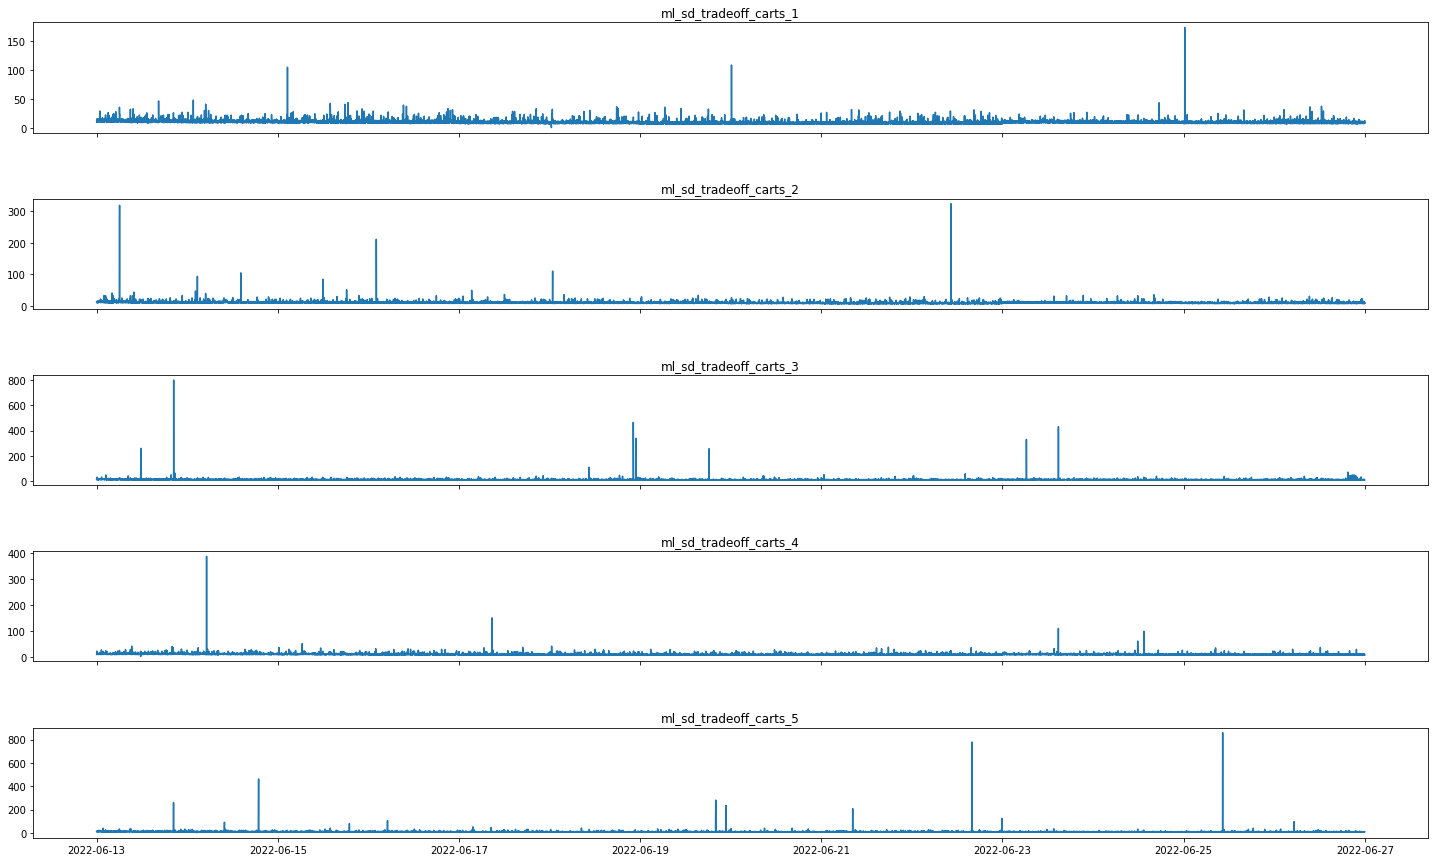

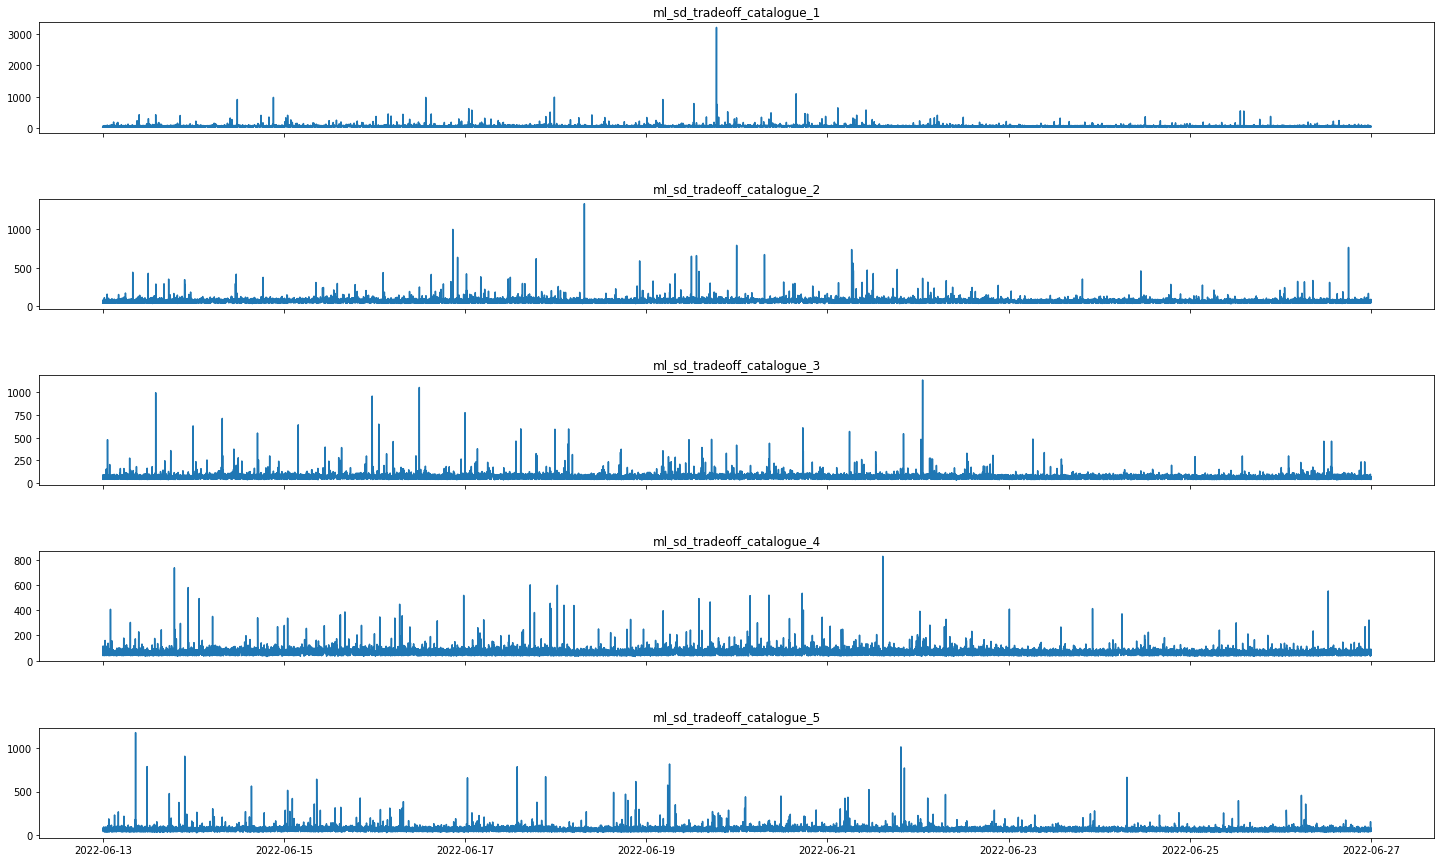

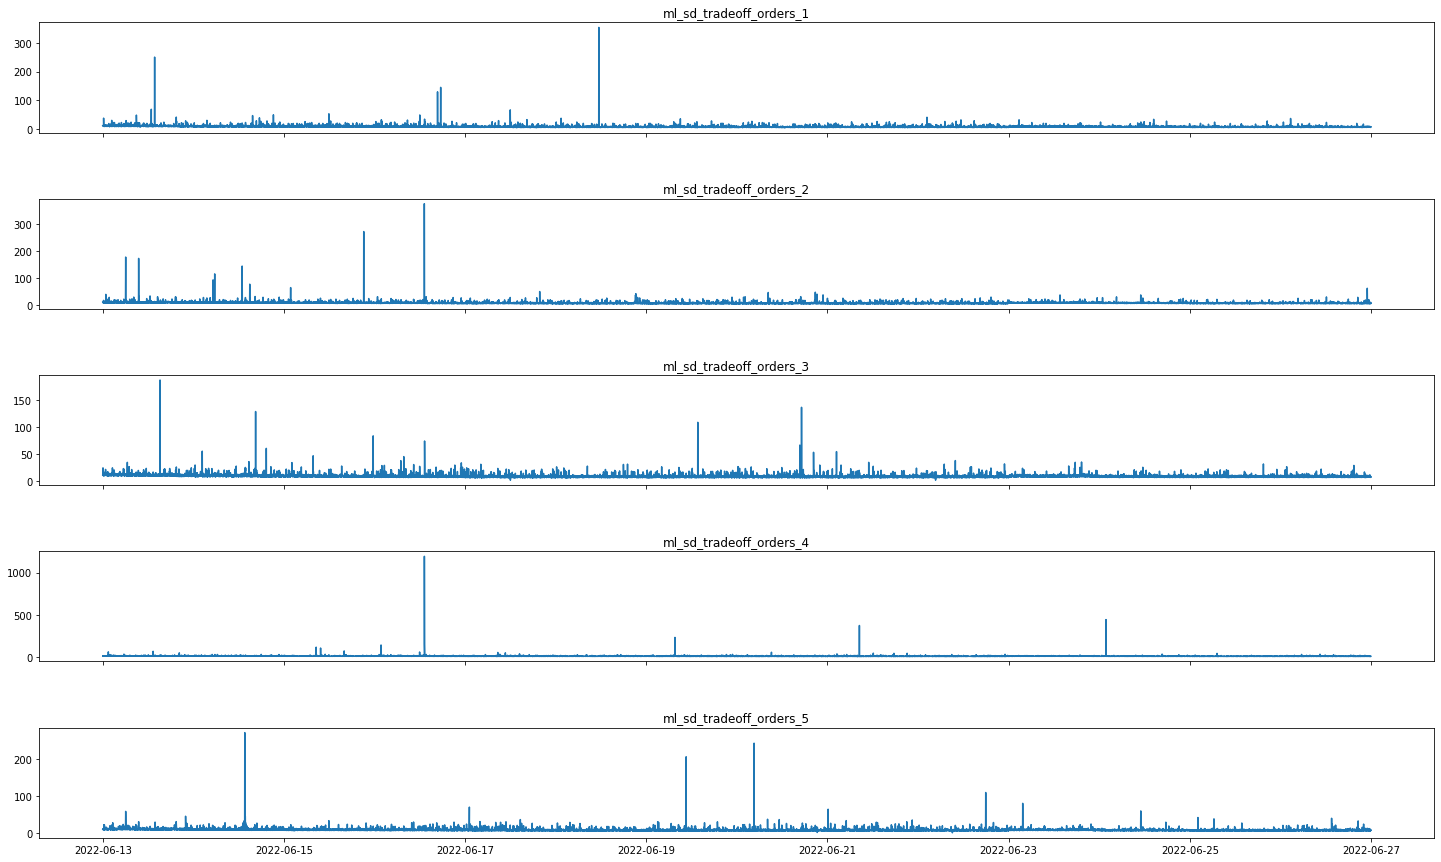

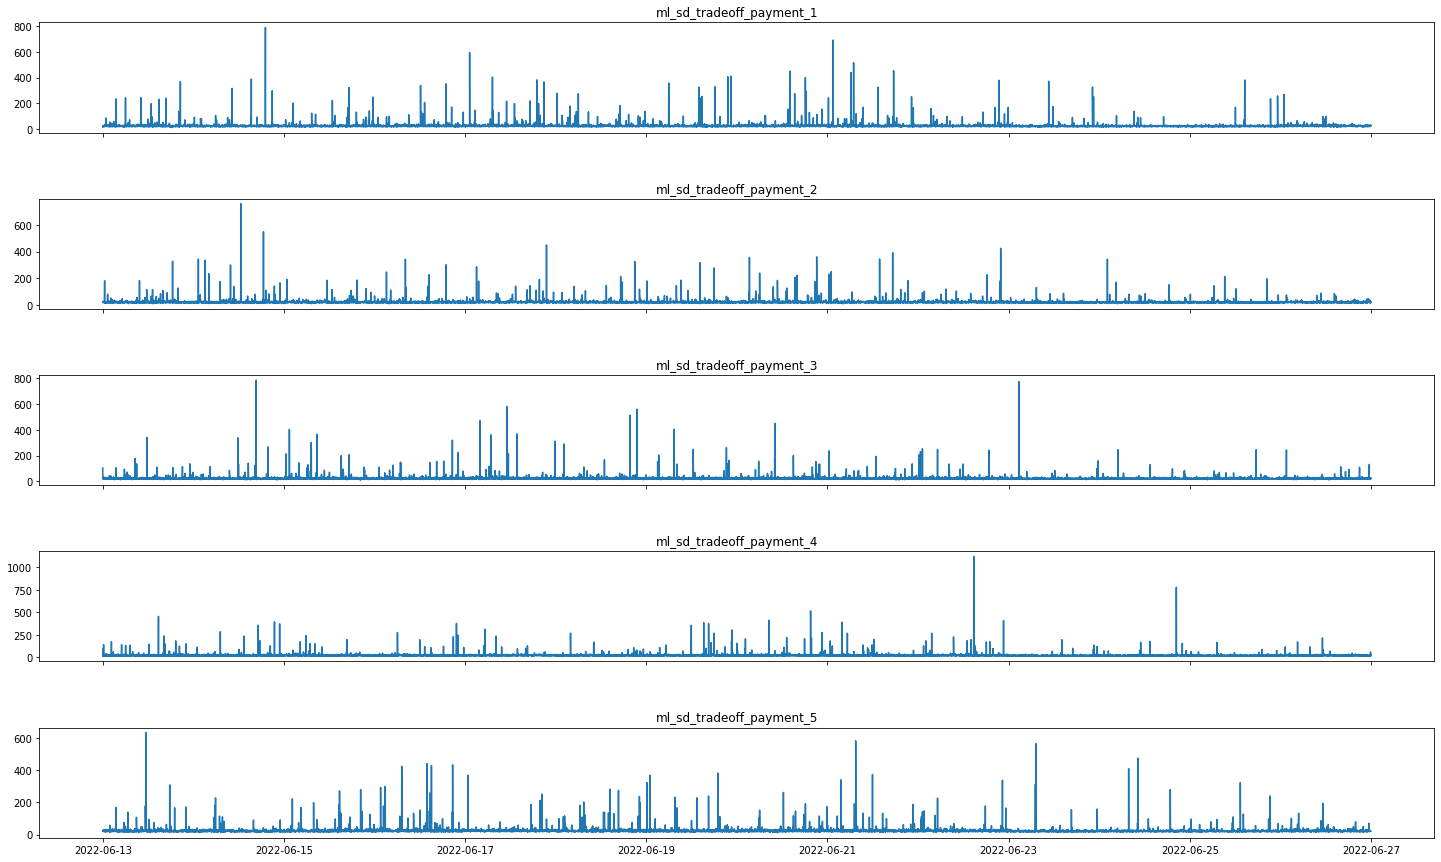

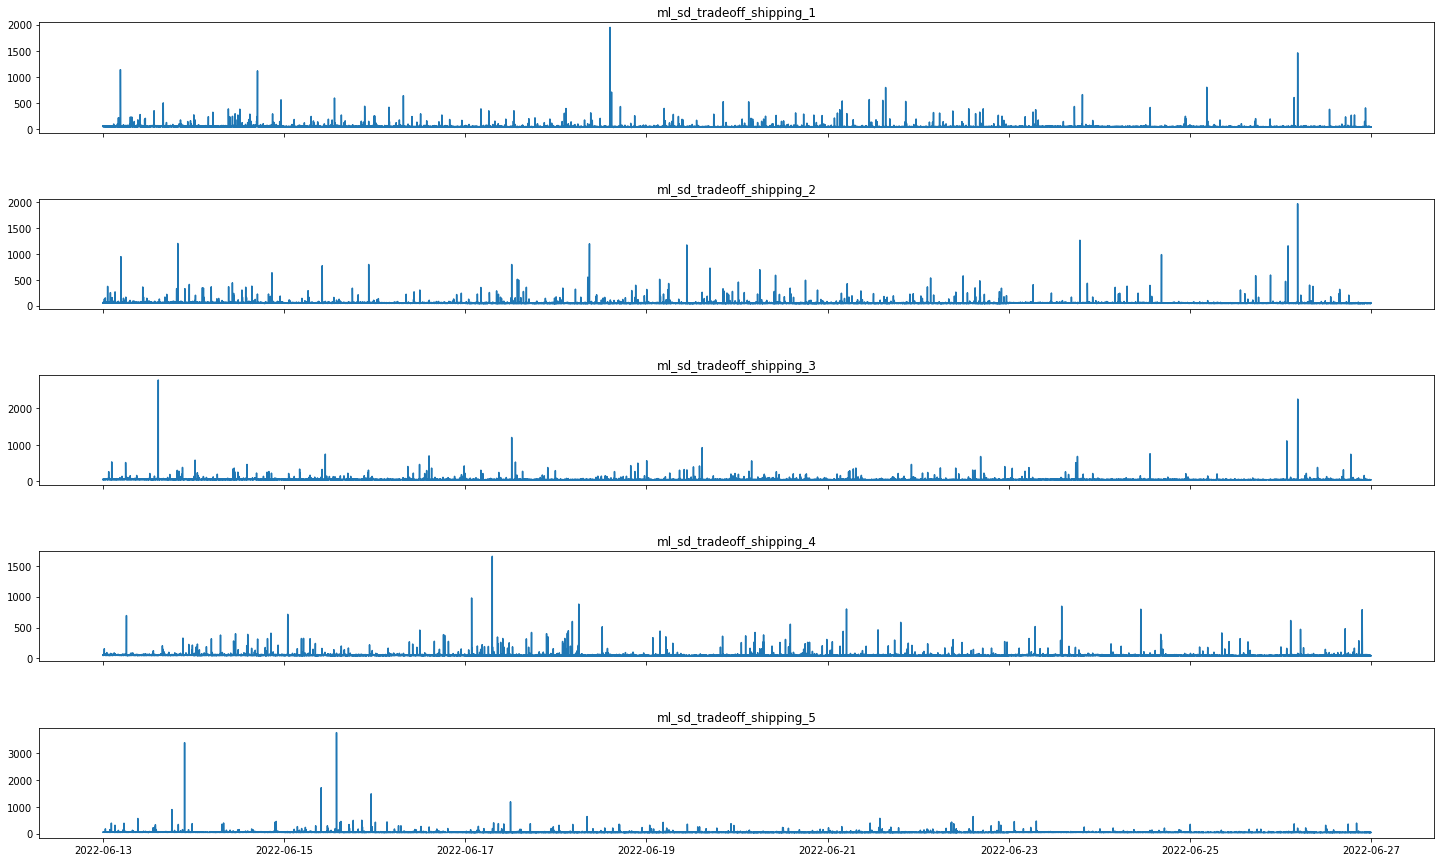

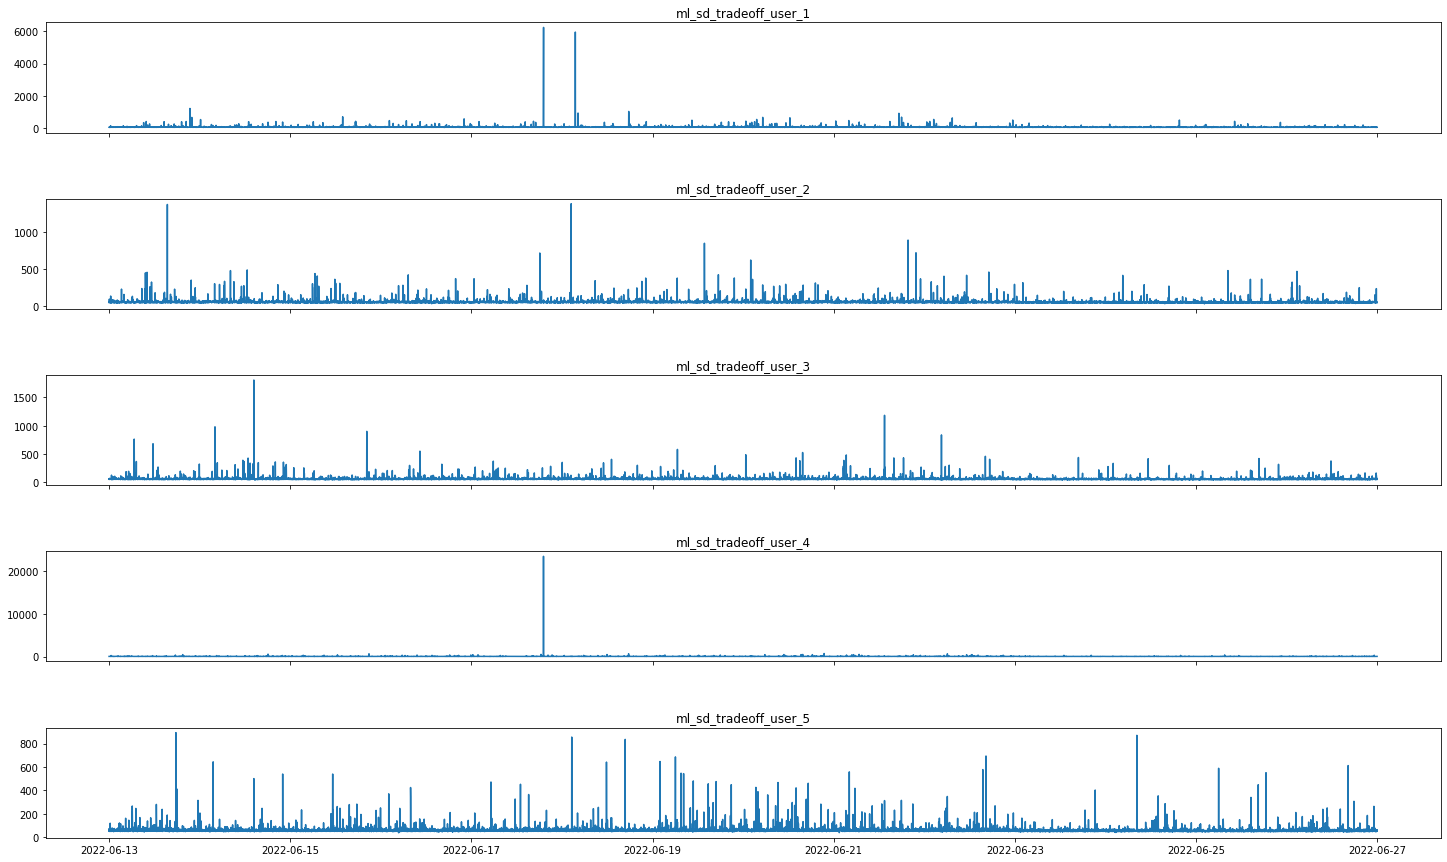

In [40]:
#
#
# ONE PLOT PER INSTANCE CONTEXT
#
#
plt.rcParams['figure.figsize'] = [25, 15]
    
for key in dfs:
    
    sub_dfs = {service_instance: sub_df for service_instance, sub_df in dfs[key].groupby(['service_instance'])}

    fig, ax = plt.subplots(5,1, sharex='col', sharey='row')
    
    
    # manage zeros value
    
    i = 0
    
    for key in sub_dfs:
        ax[i].set_title(key)
        # convert dataset in a compliant time series format
        grouper = sub_dfs[key].groupby([pd.Grouper(freq='1T'), 'service_instance'])
        sub_df_ts = grouper.mean().unstack()
        
        
        ax[i].plot(sub_df_ts.iloc[:])
        
        i = i + 1
        
    plt.subplots_adjust(hspace=0.6)    
    

    plt.show()
        

In [ ]:
#
# 
# LEARNING
#
#

In [136]:
# retrieve sub dataset
sub_df = dfs['catalogue']
display(sub_df.shape)
display(sub_df.head())

(32804, 3)

,time_delta,service_instance,service_type
timestamp,,,
2022-05-23 00:00:20.577554387,0.981502,ml_sd_tradeoff_catalogue_5,catalogue
2022-05-23 00:00:31.737778300,0.923382,ml_sd_tradeoff_catalogue_3,catalogue
2022-05-23 00:00:38.844218812,0.442870,ml_sd_tradeoff_catalogue_1,catalogue
2022-05-23 00:00:46.905100969,0.885930,ml_sd_tradeoff_catalogue_4,catalogue
2022-05-23 00:01:03.901553993,0.746166,ml_sd_tradeoff_catalogue_2,catalogue


In [103]:
# retrieve number instances
n_instances = sub_df['service_instance'].nunique()
display(n_instances)

5

In [124]:
# convert dataset in a compliant time series format
grouper = sub_df.groupby([pd.Grouper(freq='1T'), 'service_instance'])
sub_df_ts = grouper.mean().unstack().fillna(0)
display(sub_df_ts.shape)
display(sub_df_ts.head())

(9816, 5)

time_delta                             \
service_instance    ml_sd_tradeoff_catalogue_1 ml_sd_tradeoff_catalogue_2   
timestamp                                                                   
2022-05-23 00:00:00                   0.442870                   0.000000   
2022-05-23 00:01:00                   0.000000                   0.746166   
2022-05-23 00:02:00                   0.856385                   0.480892   
2022-05-23 00:03:00                   0.634424                   0.839403   
2022-05-23 00:04:00                   0.785571                   0.000000   

                                                                           \
service_instance    ml_sd_tradeoff_catalogue_3 ml_sd_tradeoff_catalogue_4   
timestamp                                                                   
2022-05-23 00:00:00                   0.923382                   0.885930   
2022-05-23 00:01:00                   0.826478                   0.000000   
2022-05-23 00:02:00                   0.000000                   0.913113   
2022-05-23 00:03:00                   0.902722                   0.492484   
2022-05-23 00:04:00                   0.942268                   0.975501   

                                                
service_instance    ml_sd_tradeoff_catalogue_5  
timestamp                                       
2022-05-23 00:00:00                   0.981502  
2022-05-23 00:01:00                   0.611941  
2022-05-23 00:02:00                   0.686933  
2022-05-23 00:03:00                   0.000000  
2022-05-23 00:04:00                   0.652879

In [108]:
## DEFINE VARIABLES
num_forecasts = 1
# specify the number of lag minutes
prev_steps = 10

# normalize features
values = sub_df_ts.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
display(scaled)

array([[0.4375313 , 0.26312276, 0.38502259, 0.36383776, 0.43273254],
       [0.51302272, 0.2528771 , 0.30952373, 0.24555662, 0.39729581],
       [0.55416458, 0.29913551, 0.32414635, 0.28097194, 0.54824216],
       ...,
       [0.42015533, 0.53016028, 0.20826604, 0.18107457, 0.49616628],
       [0.37830422, 0.074201  , 0.26961232, 0.19692222, 0.43161699],
       [0.43279033, 0.31700677, 0.20046993, 0.16306901, 0.54896047]])

In [109]:
# frame as supervised learning
reframed = series_to_supervised(scaled, prev_steps, num_forecasts)
values = reframed.values
display(reframed.head())


,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
10,0.437531,0.263123,0.385023,0.363838,0.432733,0.513023,0.252877,0.309524,0.245557,0.397296,...,0.527456,0.514059,0.273424,0.262668,0.424911,0.576021,0.276002,0.343929,0.328455,0.428733
11,0.513023,0.252877,0.309524,0.245557,0.397296,0.554165,0.299136,0.324146,0.280972,0.548242,...,0.576021,0.276002,0.343929,0.328455,0.428733,0.478499,0.410378,0.273009,0.385854,0.372666
12,0.554165,0.299136,0.324146,0.280972,0.548242,0.633867,0.445058,0.399489,0.372116,0.499417,...,0.478499,0.410378,0.273009,0.385854,0.372666,0.468459,0.361155,0.318038,0.251974,0.401509
13,0.633867,0.445058,0.399489,0.372116,0.499417,0.299143,0.423645,0.450058,0.413673,0.582013,...,0.468459,0.361155,0.318038,0.251974,0.401509,0.467255,0.345584,0.335064,0.257885,0.473999
14,0.299143,0.423645,0.450058,0.413673,0.582013,0.699524,0.460849,0.564427,0.398231,0.444928,...,0.467255,0.345584,0.335064,0.257885,0.473999,0.652337,0.337398,0.362826,0.274085,0.451179


In [110]:
# split into train and test sets
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
display(train.shape)
display(test.shape)

(1403, 55)

(602, 55)

In [111]:
# split into input and outputs
n_obs = prev_steps * n_instances
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]

df_train_X = pd.DataFrame(train_X)
display(train_X.shape, train_y.shape)
display(test_X.shape, test_y.shape)

(1403, 50)

(1403, 5)

(602, 50)

(602, 5)

In [112]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], prev_steps, n_instances))
test_X = test_X.reshape((test_X.shape[0], prev_steps, n_instances))
display(train_X.shape)
display(test_X.shape)

(1403, 10, 5)

(602, 10, 5)

In [113]:
display(sub_df_ts)

time_delta                             \
service_instance    ml_sd_tradeoff_catalogue_1 ml_sd_tradeoff_catalogue_2   
timestamp                                                                   
2022-05-23 00:00:00                   0.679812                   0.688820   
2022-05-23 00:05:00                   0.797107                   0.677222   
2022-05-23 00:10:00                   0.861031                   0.729587   
2022-05-23 00:15:00                   0.984868                   0.894771   
2022-05-23 00:20:00                   0.464792                   0.870532   
...                                        ...                        ...   
2022-05-29 23:35:00                   0.729897                   0.668842   
2022-05-29 23:40:00                   0.507172                   0.855087   
2022-05-29 23:45:00                   0.652815                   0.991107   
2022-05-29 23:50:00                   0.587789                   0.474961   
2022-05-29 23:55:00                   0.672446                   0.749817   

                                                                           \
service_instance    ml_sd_tradeoff_catalogue_3 ml_sd_tradeoff_catalogue_4   
timestamp                                                                   
2022-05-23 00:00:00                   0.898713                   0.816757   
2022-05-23 00:05:00                   0.791995                   0.681731   
2022-05-23 00:10:00                   0.812664                   0.722160   
2022-05-23 00:15:00                   0.919160                   0.826207   
2022-05-23 00:20:00                   0.990639                   0.873647   
...                                        ...                        ...   
2022-05-29 23:35:00                   0.545768                   0.614873   
2022-05-29 23:40:00                   0.713631                   0.451202   
2022-05-29 23:45:00                   0.648868                   0.608120   
2022-05-29 23:50:00                   0.735581                   0.626212   
2022-05-29 23:55:00                   0.637848                   0.587566   

                                                
service_instance    ml_sd_tradeoff_catalogue_5  
timestamp                                       
2022-05-23 00:00:00                   0.733314  
2022-05-23 00:05:00                   0.673262  
2022-05-23 00:10:00                   0.929058  
2022-05-23 00:15:00                   0.846319  
2022-05-23 00:20:00                   0.986286  
...                                        ...  
2022-05-29 23:35:00                   0.605064  
2022-05-29 23:40:00                   0.559092  
2022-05-29 23:45:00                   0.840809  
2022-05-29 23:50:00                   0.731423  
2022-05-29 23:55:00                   0.930275  

[2015 rows x 5 columns]

In [38]:
#
#
# MODELS TRAINING
#
#

for key in dfs:
    # retrieve sub dataset
    sub_df = dfs[key]

    # retrieve number instances
    n_instances = sub_df['instance'].nunique()
    # convert dataset in a compliant time series format
    grouper = sub_df.groupby([pd.Grouper(freq='1T'), 'instance'])
    sub_df_ts = grouper.mean().unstack().fillna(0)

    ## DEFINE VARIABLES
    num_forecasts = 1
    # specify the number of lag hours
    prev_steps = 10

    values = sub_df_ts.values
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, prev_steps, num_forecasts)
    values = reframed.values
    # split into train and test sets
    n_train_hours = int(len(values) * 0.7)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    n_obs = prev_steps * n_instances
    train_X, train_y = train[:, :n_obs], train[:, n_obs:]
    test_X, test_y = test[:, :n_obs], test[:, n_obs:]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], prev_steps, n_instances))
    test_X = test_X.reshape((test_X.shape[0], prev_steps, n_instances))
    
    # history 
    history = History()
    
    # design network
    model = Sequential()
    model.add(LSTM(110, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(units=55))
    model.add(Dense(n_instances * num_forecasts))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[history])
        
    # save history
    histories[key] = history
    
    # save model and scaler
    model_file_name = key + '.model.sav'
    joblib.dump(model, model_file_name)
    file_names.append(model_file_name)

print(json.dumps(file_names))

Epoch 1/10
42/42 [==============================] - 3s 27ms/step - loss: 0.0018 - val_loss: 8.9426e-04
Epoch 2/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8311e-04
Epoch 3/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8480e-04
Epoch 4/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8572e-04
Epoch 5/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8617e-04
Epoch 6/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8538e-04
Epoch 7/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8478e-04
Epoch 8/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8483e-04
Epoch 9/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8612e-04
Epoch 10/10
42/42 [==============================] - 1s 13ms/step - loss:

INFO:tensorflow:Assets written to: ram://263e5329-0ae8-4ca3-835f-bbd0c0b36968/assets


INFO:tensorflow:Assets written to: ram://263e5329-0ae8-4ca3-835f-bbd0c0b36968/assets


Epoch 1/10
86/86 [==============================] - 4s 20ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 2/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 3/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 4/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 5/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 6/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 7/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 8/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 9/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 10/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062


INFO:tensorflow:Assets written to: ram://7b9489aa-2bbd-40f9-9d56-7f9ffd458349/assets


INFO:tensorflow:Assets written to: ram://7b9489aa-2bbd-40f9-9d56-7f9ffd458349/assets


Epoch 1/10
48/48 [==============================] - 4s 25ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 2/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 3/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 4/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 5/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 6/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 7/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 8/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 9/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 10/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022


INFO:tensorflow:Assets written to: ram://270adbc6-5a0f-47a7-ad91-a4ad47d7e271/assets


INFO:tensorflow:Assets written to: ram://270adbc6-5a0f-47a7-ad91-a4ad47d7e271/assets


Epoch 1/10
71/71 [==============================] - 4s 21ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 2/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0016


INFO:tensorflow:Assets written to: ram://2ef34c3c-23f0-4c6f-9611-baa500188820/assets


INFO:tensorflow:Assets written to: ram://2ef34c3c-23f0-4c6f-9611-baa500188820/assets


Epoch 1/10
63/63 [==============================] - 4s 22ms/step - loss: 0.0115 - val_loss: 0.0043
Epoch 2/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 3/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 4/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 5/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 6/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 7/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 8/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 9/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 10/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043


INFO:tensorflow:Assets written to: ram://41971a48-b045-46d7-ba7d-56c6d3dda3ae/assets


INFO:tensorflow:Assets written to: ram://41971a48-b045-46d7-ba7d-56c6d3dda3ae/assets


Epoch 1/10
86/86 [==============================] - 4s 19ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 2/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 3/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 4/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 5/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 6/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 7/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 8/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 9/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 10/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051


INFO:tensorflow:Assets written to: ram://51ae1139-e2b1-4395-b2b7-64a10d4c47cc/assets


INFO:tensorflow:Assets written to: ram://51ae1139-e2b1-4395-b2b7-64a10d4c47cc/assets


["carts.model.sav", "catalogue.model.sav", "orders.model.sav", "payment.model.sav", "shipping.model.sav", "user.model.sav"]


In [24]:
histories

{'carts': <keras.callbacks.History at 0x7eff6412b850>,
 'catalogue': <keras.callbacks.History at 0x7eff28636fa0>,
 'orders': <keras.callbacks.History at 0x7eff45782cd0>,
 'payment': <keras.callbacks.History at 0x7effa40a33a0>,
 'shipping': <keras.callbacks.History at 0x7eff2b93be50>,
 'user': <keras.callbacks.History at 0x7eff2a9d2430>}

In [31]:
history=histories['catalogue']

In [39]:

def plot_history_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Plotting carts loss:


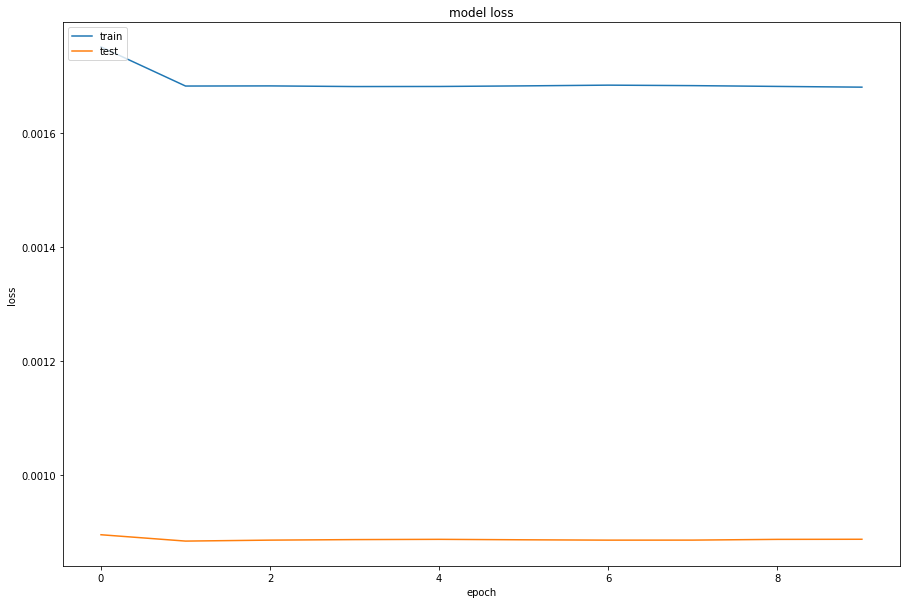

Plotting catalogue loss:


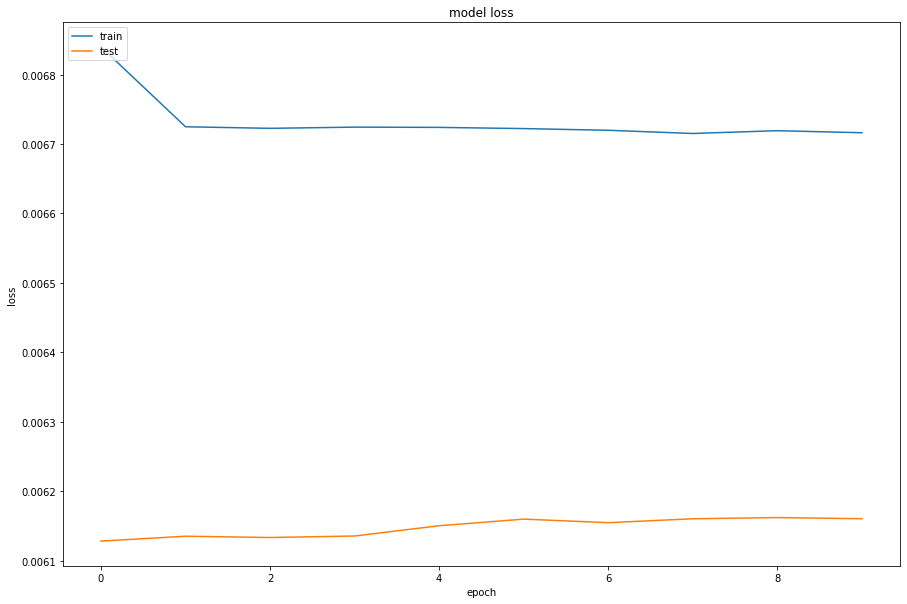

Plotting orders loss:


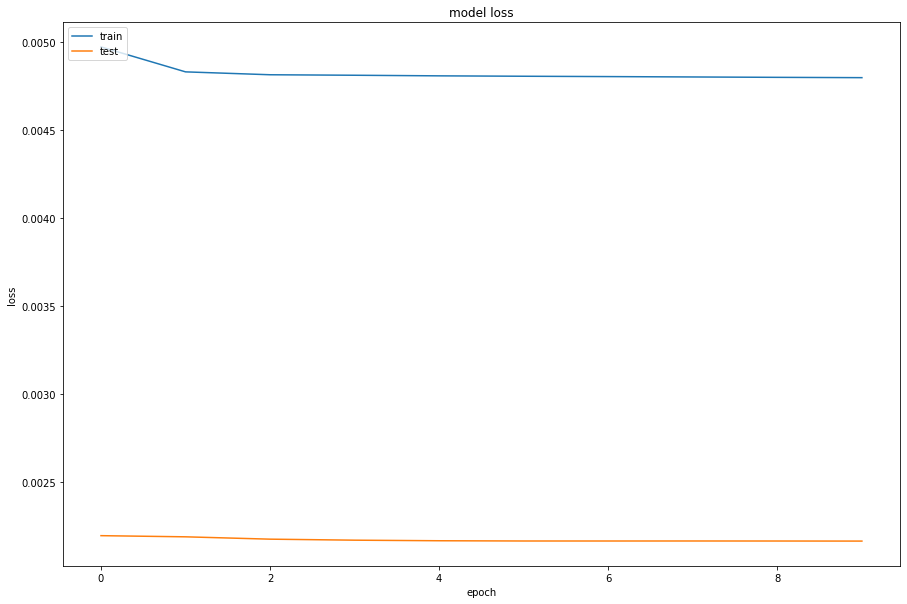

Plotting payment loss:


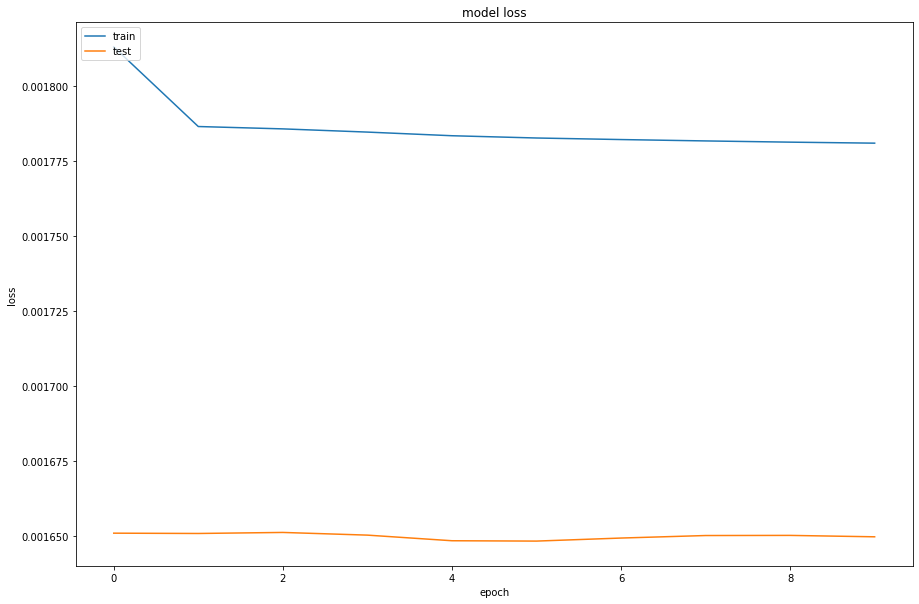

Plotting shipping loss:


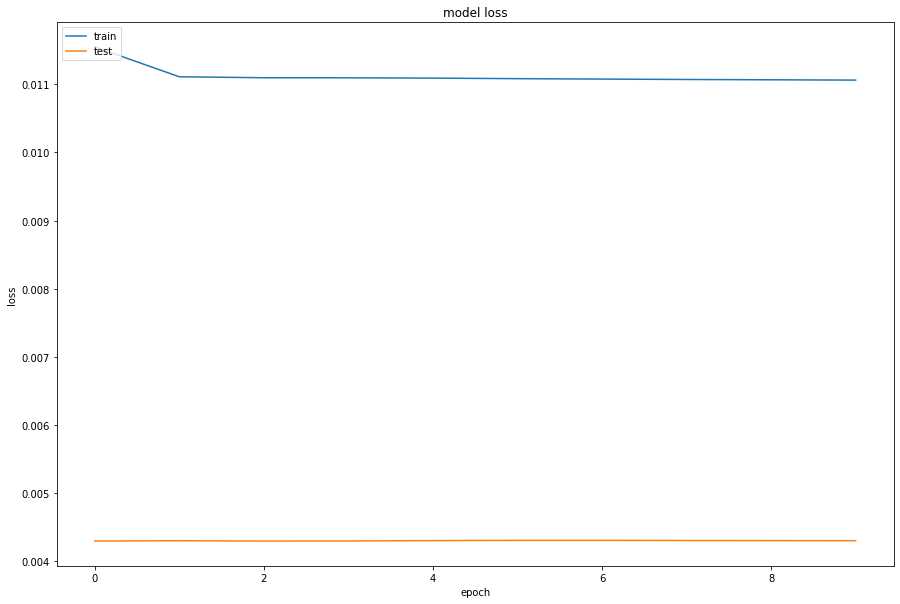

Plotting user loss:


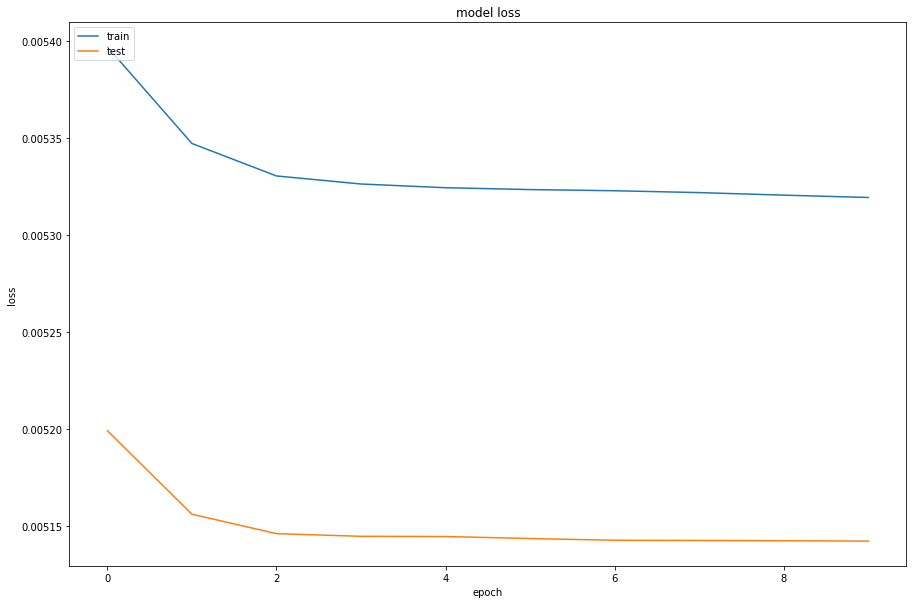

In [44]:
for k in histories:
    print(f"Plotting {k} loss:")
    plot_history_loss(histories[k])